# PCNN для сегментации изображения

Pulse-Coupled neural network основана на одной из моделей зрительной ткани головного мозга. Она позволяет выделять насыщенные сегменты из изображения. На вход подаются сигналы, которые могут быть как с фиксированной так и с изменчивой амплитудой. На выходе идет двоичный сигнал. Эта сеть применяется, как правило, для предварительной обработки изображения, для выделения значимых деталей перед последующей обработкой изображения. Хорошо себя показывает на видеоряде.

На вход нейрона подаются выходы соседних нейронов и входной сигнал от одного или нескольких пикселов или нейронов.
![](https://i.ibb.co/CnTW16C/pcnn-connection-scheme.jpg)
![](https://i.ibb.co/qj21LM4/full-neuron-scheme.jpg)

**Feeding part**  
Через эту часть приходит внешний импульс.

**Linking part**  
Через эту часть приходят выходящие импульсы соседних нейронов.

**Threshold**  
Если состояние нейрона на определенной итерации превышает порог, то формируется импульс, а порог повышается. Если на итерации порог не превышен, то порог опускается.

**Fast linking**  
Импульс нейрона поступает по linking part к другим нейронам, они, в свою очередь, испускают импульс, и так далее...
В реальных условиях импульс проходит через всь кору, постепенно затухая, притом быстрее входящего сигнала. В дискретной системе импульс доходит до нейрона, связанного напрямую и на следующей итерации сменяется уже новым импульсом. Чтобы импульс по linking part распорстранялся быстрее и через всю сеть, после на каждой итерации проходят еще несколько итераций с тем же входящим импульсом, пока выходящий импульс не перестанет изменяться, притом порог пересчитывается только в конце этой процедуры.

**Time sugnature**  
С помощью PCNN можно сформировать ряд, характеризующий определенное изображение. По горитонтали - итерации, по вертикали - суммарное количество импульсов на итерации. При повороте изображения этот ряд не будет меняться.

![](https://i.ibb.co/nLrBsG9/formulas.jpg)

Как сказано в книге *T. Lindblad J.M. Kinser ImageProcessing UsingPulse-Coupled NeuralNetworks*, длинные связи плохо влияют на качество сегментации, так что используются короткие связи только с соседними нейронами.

In [1]:
# Добавление корня библиотеки в pythonpath
import sys
import os
os.chdir('..')
os.chdir('..')
libDir = os.path.dirname(os.getcwd())
print(f'lib dir: {libDir}')
sys.path.append(libDir)

In [2]:
from PcnnLib.network_lib.network import Network
from PcnnLib.network_lib.neuron_factories.full_neuron_factory import FullNeuronFactory
from PcnnLib.image_preprocessing.images_pipeline import ImagesPipeline
from PcnnLib.image_preprocessing.directory_pipeline import DirectoryPipeline
from PcnnLib.image_preprocessing.image_converters import denormalize_spikes_scaled, spikes_to_img, save_img, resize_img
from PcnnLib.metrics.time_signature import TimeSignature
from PcnnLib.metrics.mse import Mse
from PcnnLib.tools.grid_search import GridSearch
from PcnnLib.tools.spike_collector import collect_spikes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# вспомогательные функции
def save_img_custom(spikes, file_name):
    dn_spikes = denormalize_spikes(spikes)
    img = spikes_to_img(dn_spikes)
    save_img(img, f'{RESULTS_DIR}\\{file_name}.jpg')

def print_images(spike_packets, img_numbers):
    f = plt.figure(figsize=(20,10))
    i = 0
    n = len(img_numbers)
    for number in img_numbers:
        dn_spikes = denormalize_spikes_scaled(spike_packets[number])
        img = spikes_to_img(dn_spikes)
        f.add_subplot(1, n, i + 1)
        plt.imshow(img)
        i += 1
    plt.show()

def print_time_signature(signature):
    plt.plot(signature)
    plt.xlabel('iterations')
    plt.ylabel('total spike')
    plt.show()

In [4]:
IMG_SIZE = (328, 180)
IMAGES_DIR = r'C:\Users\azpk3\OneDrive\Рабочий стол\DataMining\RawData\Images'
MASKS_DIR = r'C:\Users\azpk3\OneDrive\Рабочий стол\DataMining\RawData\Masks'
RESULTS_DIR = r'C:\Users\azpk3\OneDrive\Рабочий стол\DataMining\Temp'

Подбираем основные гиперпараметры с помощью grid search с использованием размеченного, тестового набора данных с масками.

In [ ]:
neuron_params = dict(
    feeding_scale=0.125, 
    linking_scale=0.125, 
    threshold_scale=30, 
    linking_strength=1,
    af=0.1,
    al=0.1,
    at=0.8)
best_param, mse = GridSearch().find_best_value(IMG_SIZE, IMAGES_DIR, MASKS_DIR, neuron_params, 'threshold_scale', 20, 40, 1, ["91.jpg", "92.jpg", "93.jpg", "96.jpg", "118.jpg"])
print(best_param)
print(mse)

In [ ]:
neuron_params['threshold_scale'] = best_param
best_param, mse = GridSearch().find_best_value(IMG_SIZE, IMAGES_DIR, MASKS_DIR, neuron_params, 'at', 0.1, 1, 0.1)
print(best_param)
print(mse)

Строим однослойный фильтр с применением fast linking, устанавливаем силу связи между feeding part и linking part, как 1 к 2.

In [5]:
time_signature_metric = TimeSignature()
network = Network(fast_linking=True, metrics=[time_signature_metric])
neuron_factory = FullNeuronFactory(
    feeding_scale=0.125, 
    linking_scale=0.125, 
    threshold_scale=27, 
    linking_strength=1,
    af=0.1,
    al=0.1,
    at=0.6)
network.init_layer(IMG_SIZE, neuron_factory)

Генерируем сигнал от одного изображения, с длительностью симуляции в 30 итераций.
Изображение преобразуется в полутоновую расцветку и преобразуются в бинарный вид с порогом, равным среднему значению пиксела изображения.

In [6]:
i = 0
img_pipeline = ImagesPipeline(IMG_SIZE, IMAGES_DIR, ["92.jpg"], None)
img_spikes, mask_spikes = next(img_pipeline)
mask_spikes = []
while i < 30:
    output_spikes = network.iterate(img_spikes, mask_spikes)
    mask_spikes.append(output_spikes)
    i += 1

Обработанное, первоначальное изображение

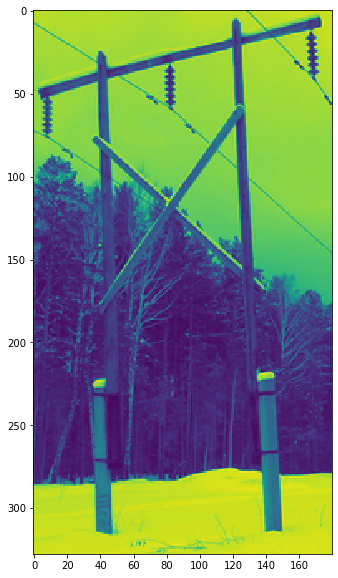

In [7]:
print_images([img_spikes], [0])

Полученное изображение на разных итерациях

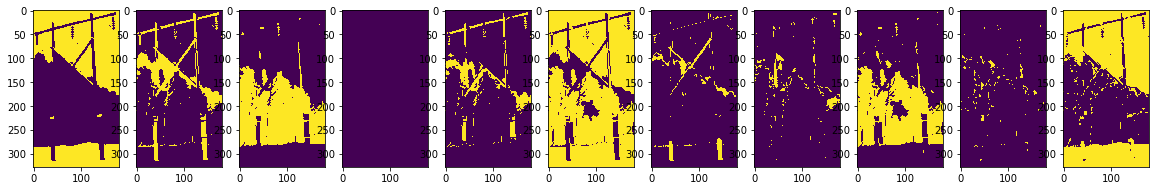

In [8]:
print_images(mask_spikes, [4,5,6,7,10,11,13,15,16,28,29])

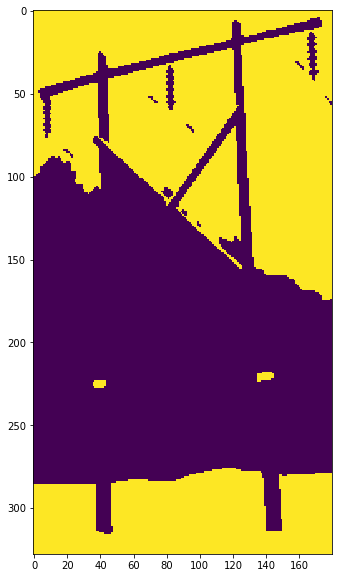

In [17]:
print_images([collect_spikes(mask_spikes, 9)], [0])

Временная подпись

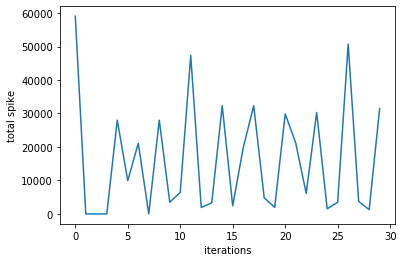

In [10]:
signature = time_signature_metric.get_signature()
print_time_signature(signature)

Изменение порога со временем

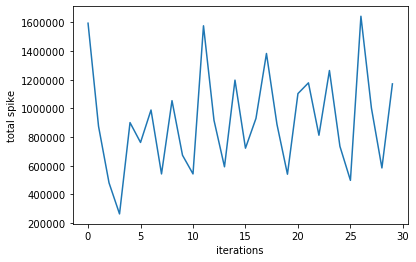

In [11]:
signature = time_signature_metric.get_thresholds()
print_time_signature(signature)